<a href="https://colab.research.google.com/github/kapitalistka/DataSienceEducation/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0. Загрузка данных

In [1]:
#!pip install kaggle
from google.colab import files
from google.colab import drive
from zipfile import ZipFile
from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
pd.options.display.float_format = "{:,.2f}".format

In [3]:
def update_kaggle_token():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
  
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

update_kaggle_token()

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [4]:
def download_kaggle_data():
  %cd /
  %cd /content
  !mkdir -p kaggle/HW3/
  %cd kaggle/HW3
  !kaggle competitions download -c sberbank-russian-housing-market
  %cd /content

download_kaggle_data();

/
/content
/content/kaggle/HW3
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
data_dictionary.txt: Skipping, found more recently modified local copy (use --force to force download)
macro.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
/content


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
file_zip_train = "kaggle/HW3/train.csv.zip"
file_train = "train.csv"

file_zip_test = "kaggle/HW3/test.csv.zip"
file_test = "test.csv"

In [15]:
raw_train_data = pd.read_csv(ZipFile(file_zip_train).open(file_train))
raw_test_data = pd.read_csv(ZipFile(file_zip_test).open(file_test))

## 1. Подготовка и  анализ данных

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder


### Общая информация о наборе данных

In [16]:
df = raw_train_data
print("Shape:   " , df.shape)
print( '\nОбщая информация о  наборе данных:')
print(df.info())

Shape:    (30471, 292)

Общая информация о  наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB
None


In [303]:
df.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,"30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00",...,"30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00","30,471.00"
mean,"15,237.92",54.21,34.40,7.67,12.56,1.25,"1,985.37",1.91,6.40,2.11,"17,657,051.42","84,056.43",0.22,0.12,"5,140.03","3,271.27",4.07,"5,354.27","8,324.97",4.71,0.11,"1,190.74",1.32,0.14,6.64,2.90,0.29,4.20,8.25,"146,306.15","67,207.79","79,098.66","11,178.81","5,723.85","5,455.01","53,667.91","27,253.59","26,414.41","19,209.71","5,811.62",...,765.90,"1,283.33","1,024.62",7.27,27.78,30.45,26.69,13.32,4.65,0.71,6.12,12.29,0.20,3.88,20.24,2.32,22.77,10.35,71.36,"1,401,057.39",30.13,"1,173,871.15",265.53,765.10,"1,278.28","1,021.69",17.81,66.20,73.44,63.47,32.06,10.78,1.77,15.05,30.25,0.44,8.65,52.80,5.99,"7,123,035.28"
std,"8,796.50",38.03,46.49,5.31,5.60,1.49,15.10,0.71,23.41,0.63,"20,649,607.99","57,871.29",0.18,0.12,"3,816.63","1,916.90",2.99,"3,989.64","3,790.06",3.45,0.33,766.65,1.49,0.44,6.57,3.29,1.51,4.74,23.54,"283,025.12","129,444.56","153,630.89","8,287.96","4,275.44","4,020.55","37,483.56","18,939.15","18,643.13","13,174.72","4,073.83",...,220.33,347.51,283.44,18.24,71.83,69.53,70.86,41.28,16.88,2.78,15.41,25.79,0.45,13.19,18.84,2.27,11.21,5.65,155.34,"2,303,052.49",23.92,"1,004,809.88",514.54,151.66,235.05,193.17,33.27,125.93,126.17,124.08,73.47,28.39,5.42,29.12,47.35,0.61,20.58,46.29,4.89,"4,780,111.33"
min,1.00,0.00,0.00,0.00,0.00,0.00,"1,860.00",0.00,0.00,1.00,"2,081,627.76","2,546.00",0.00,0.00,175.00,0.00,0.00,168.00,"1,012.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"2,546.00","1,208.00","1,341.00",365.00,189.00,177.00,"1,633.00",863.00,771.00,548.00,156.00,...,300.00,500.00,400.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

### Проверим, сколько пропущенных значений в данных 

 51 колонка(и) содержат  пропущенные значения


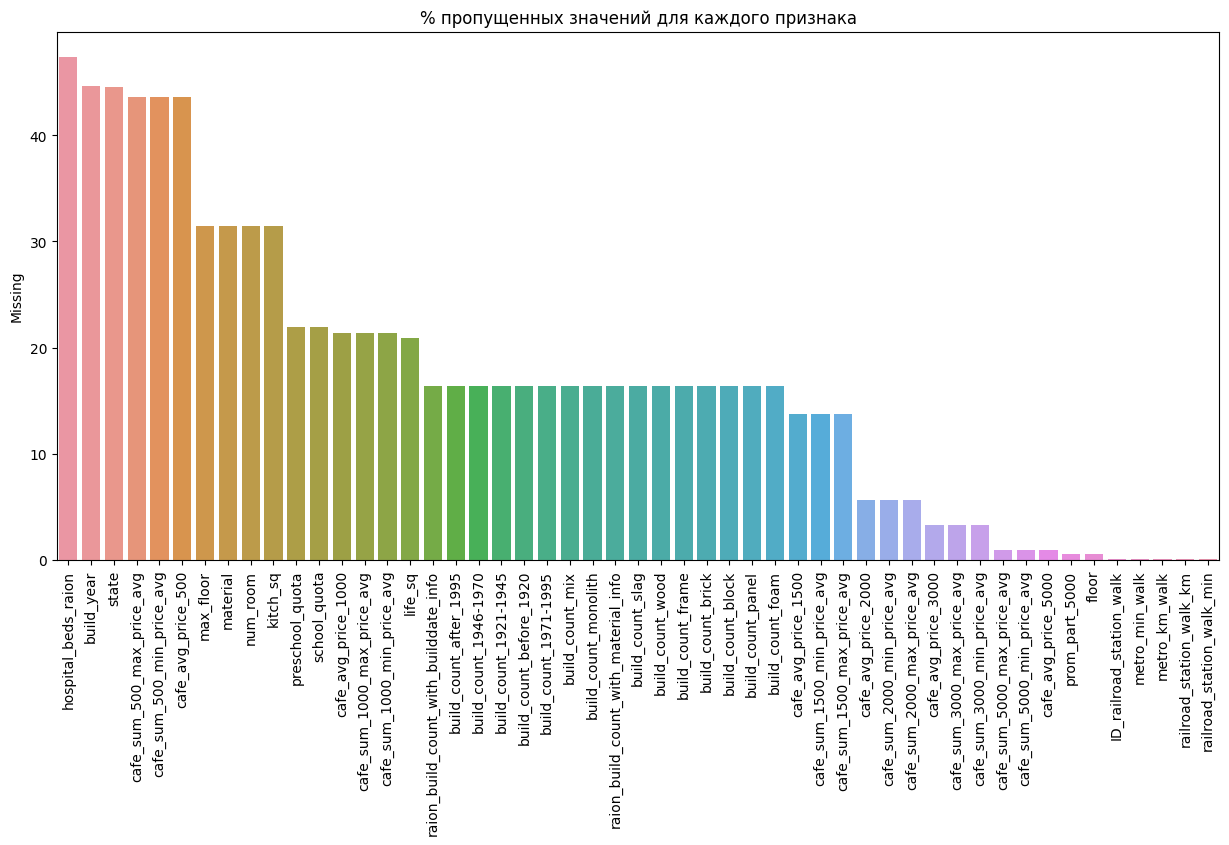

In [323]:
df_copy = df

missings_df = {}
for key in df_copy.columns:
    if df_copy[key].isnull().sum() > 0:
        missings_df[key] = (df_copy[key].isnull().sum()  /  len(df_copy[key]) ) * 100

missings_df = pd.DataFrame(missings_df,index=['Missing']).T.sort_values(by='Missing',ascending=False)

plt.figure(figsize=(15,7),dpi=100)
plt.xticks(rotation=90)
sns.barplot(y=missings_df.Missing, x = missings_df.index, orient='v').set_title('% пропущенных значений для каждого признака')
print( f" {missings_df.shape[0]} колонка(и) содержат  пропущенные значения.")

### Отредактируем список признаков для моделей обучения

Предположу, что из тех признаков, в которых есть пропущенные данные, нам могут быть полезны такие, как build_year, state, max_floor, material, num_room, floor. Попробуем заполнить пропущенные значения: 
1) для build_year будем счтать, что валидны значения с 1700г до 2022г, к значениям меньшим 100 прибавим 1900, остальные заменим средним значением.
2) для state очевидно, что валидный диапазон значений с 1 до 5, заменям выбросы и пропущенные средним.
3) для material пропущенные значения заменям 0.



In [17]:

NUMERIC_COLS_WITH_MISSING_VALUES = ['0_6_all', 'cafe_avg_price_1500', 'build_count_slag', 'green_part_1000', 'cafe_count_1000', 'mosque_count_1500', 
           'railroad_station_avto_min', 'market_shop_km', 'build_count_foam', 'sport_count_1000', 'material', 'leisure_count_5000', 'cafe_count_3000_price_1000', 
           'mosque_count_5000', 'big_church_count_500', 'preschool_education_centers_raion', 'green_zone_part', '16_29_male', 'school_km', 'hospice_morgue_km', 
           'power_transmission_line_km', 'mosque_count_1000', 'university_top_20_raion', 'ID_bus_terminal', 'cafe_count_2000', 'school_education_centers_top_20_raion', 
           'raion_build_count_with_builddate_info', '7_14_male', 'prom_part_5000', 'cafe_sum_5000_max_price_avg', 'exhibition_km', 'big_road1_km', 
           'cafe_count_3000_na_price', 'big_church_count_3000', 'cafe_count_1500_price_high', 'metro_km_avto', 'young_female', 'cafe_count_500_price_4000', 
           'cafe_sum_1500_min_price_avg', 'area_m', 'prom_part_2000', 'green_part_3000', 'mosque_count_500', 'green_part_1500', 'cafe_count_3000_price_high', 
           'life_sq', 'sadovoe_km', 'church_count_3000', 'build_count_brick', 'sport_count_500', 'office_count_1500', 'school_education_centers_raion', 
           'cafe_count_5000_price_4000', 'trc_sqm_1500', 'workplaces_km', '0_17_all', '0_6_male', 'office_raion', 'ID_railroad_station_walk', 'cafe_count_1500', 
           'cafe_avg_price_5000', 'market_count_500', 'water_km', 'cafe_count_5000', 'industrial_km', 'cafe_count_2000_price_4000', 'cafe_count_1500_price_4000', 
           'market_count_2000', 'cafe_count_500_price_2500', 'cafe_avg_price_1000', 'metro_km_walk', 'church_count_500', 'healthcare_centers_raion', 
           'shopping_centers_km', 'cafe_count_3000_price_500', 'trc_count_1000', 'cafe_sum_2000_min_price_avg', 'cafe_count_500_price_1500', 'market_count_5000', 
           'kindergarten_km', 'cafe_count_500_price_high', 'big_road2_km', 'ID_railroad_station_avto', 'male_f', 'culture_objects_top_25_raion', 'office_count_2000', 
           'office_count_1000', 'build_count_panel', 'public_transport_station_min_walk', 'cafe_sum_1000_max_price_avg', 'cafe_count_1000_price_1500', '7_14_female',
            'build_count_frame', 'trc_count_500', '0_13_female', 'leisure_count_1500', 'cafe_count_3000_price_2500', 'water_treatment_km', 'green_zone_km', 
            'cafe_count_2000_price_high', 'work_male', 'full_all', 'cafe_sum_500_min_price_avg', 'trc_sqm_500', 'big_church_count_2000', 'trc_sqm_3000', 
            '0_17_female', '16_29_all', 'trc_sqm_5000', 'build_count_wood', 'cafe_count_1500_price_1000', 'bus_terminal_avto_km', 'build_count_1971-1995', 
            '16_29_female', 'oil_chemistry_km', 'park_km', 'office_sqm_1000', 'cafe_count_1000_na_price', 'cafe_sum_3000_max_price_avg', 'cafe_count_5000_price_1500',
             'big_church_count_1000', 'green_part_5000', 'work_female', 'public_transport_station_km', 'ID_metro', 'build_year', 'cafe_count_2000_price_1500', 
             'cafe_count_1000_price_500', 'office_sqm_500', 'green_part_2000', 'cafe_avg_price_2000', 'radiation_km', 'leisure_count_2000', 'cafe_count_500_price_1000', 
             'museum_km', '0_6_female', 'church_count_2000', 'cafe_count_5000_price_1000', 'cemetery_km', 'cafe_sum_3000_min_price_avg', 'cafe_count_500', 
             'hospital_beds_raion', 'railroad_km', 'sport_count_1500', 'cafe_count_3000_price_4000', '0_17_male', 'railroad_station_walk_min', 
             'cafe_sum_500_max_price_avg', 'big_church_count_5000', 'ts_km', 'railroad_station_avto_km', 'raion_popul', 'trc_count_3000', 'sport_objects_raion', 
             'cafe_count_1500_na_price', 'cafe_sum_2000_max_price_avg', 'swim_pool_km', 'cafe_count_2000_price_2500', 'big_market_km', 'cafe_sum_5000_min_price_avg', 
             'cafe_count_5000_price_2500', 'full_sq', 'build_count_monolith', 'prom_part_500', 'nuclear_reactor_km', 'additional_education_raion', 'leisure_count_1000', 
             'cafe_count_2000_na_price', 'bulvar_ring_km', 'cafe_count_1500_price_500', 'state', 'mosque_km', 'cafe_count_5000_price_high', 'sport_count_3000',
              'market_count_1500', 'incineration_km', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_3000', 'cafe_avg_price_500', 'build_count_after_1995', 
              'stadium_km', 'sport_count_5000', '0_13_all', 'theater_km', 'railroad_station_walk_km', 'public_healthcare_km', 'trc_sqm_2000', 'big_church_km', 
              'zd_vokzaly_avto_km', 'office_sqm_3000', 'mkad_km', 'build_count_before_1920', 'raion_build_count_with_material_info', 'preschool_quota', '7_14_all',
               'metro_min_avto', 'office_km', 'prom_part_1500', 'university_km', 'children_preschool', 'trc_count_5000', 'church_count_1000', 'fitness_km', 
               'trc_sqm_1000', 'office_sqm_2000', 'prom_part_3000', 'kitch_sq', 'shopping_centers_raion', 'cafe_count_1500_price_2500', 'cafe_count_2000_price_1000', 
               'cafe_count_500_price_500', 'school_quota', 'cafe_sum_1000_min_price_avg', 'office_count_3000', 'young_all', 'ID_big_road2', 'church_synagogue_km', 
               'trc_count_1500', 'indust_part', 'market_count_1000', 'office_count_5000', 'preschool_km', 'kremlin_km', 'young_male', 'office_count_500',
                'leisure_count_500', 'ekder_female', 'big_church_count_1500', 'cafe_count_1000_price_1000', 'office_sqm_5000', 'ID_railroad_terminal', 'ttk_km', 
                'thermal_power_plant_km', 'basketball_km', 'cafe_count_1000_price_4000', '0_13_male', 'max_floor', 'detention_facility_km', 'build_count_1946-1970', 
                'ice_rink_km', 'cafe_count_1000_price_high', 'prom_part_1000', 'mosque_count_3000', 'ID_big_road1', 'female_f', 'metro_min_walk',
                 'cafe_count_3000_price_1500', 'cafe_count_5000_price_500', 'cafe_count_3000', 'cafe_count_1500_price_1500', 'church_count_5000', 
                 'additional_education_km', 'trc_count_2000', 'work_all', 'cafe_count_500_na_price', 'church_count_1500', 'ekder_male', 'cafe_count_1000_price_2500', 
                 'ekder_all', 'leisure_count_3000', 'green_part_500', 'build_count_block', 'build_count_mix', 'children_school', 'office_sqm_1500', 'floor', 
                 'cafe_count_2000_price_500', 'cafe_count_5000_na_price', 'price_doc', 'catering_km', 'build_count_1921-1945', 'sport_count_2000', 'mosque_count_2000',
                  'num_room', 'market_count_3000']
                

STRING_COLS_WITH_MISSING_VALUES = ['nuclear_reactor_raion', 'product_type', 'radiation_raion', 'incineration_raion', 'railroad_terminal_raion',
                                   'big_road1_1line', 'water_1line', 'thermal_power_plant_raion', 'oil_chemistry_raion', 'big_market_raion', 
                                   'detention_facility_raion', 'ecology', 'railroad_1line', 'sub_area', 'timestamp', 'culture_objects_top_25']  

CATEGORICAL_COLS = ['product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 
                    'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 
                    'big_road1_1line', 'railroad_1line', 'ecology']  

COLS_FOR_DROP = ['id', 'timestamp']  

NUMERIC_COLS_TO_SCALE = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'area_m', 'raion_popul', 
                         'green_zone_part', 'indust_part', 'children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school',
                         'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 'hospital_beds_raion', 
                         'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 
                         'culture_objects_top_25_raion', 'shopping_centers_raion', 'office_raion', 'full_all', 'male_f', 'female_f', 'young_all', 
                         'young_male', 'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all', 'ekder_male', 'ekder_female', '0_6_all', 
                         '0_6_male', '0_6_female', '7_14_all', '7_14_male', '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', 
                         '16_29_female', '0_13_all', '0_13_male', '0_13_female', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick', 'build_count_monolith', 'build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix', 'raion_build_count_with_builddate_info', 'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995', 'build_count_after_1995', 'ID_metro', 'metro_min_avto', 'metro_km_avto', 'metro_min_walk', 'metro_km_walk', 'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_treatment_km', 'cemetery_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 'ID_railroad_station_walk', 'railroad_station_avto_km', 'railroad_station_avto_min', 'ID_railroad_station_avto', 'public_transport_station_km', 'public_transport_station_min_walk', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'big_road1_km', 'ID_big_road1', 'big_road2_km', 'ID_big_road2', 'railroad_km', 'zd_vokzaly_avto_km', 'ID_railroad_terminal', 'bus_terminal_avto_km', 'ID_bus_terminal', 'oil_chemistry_km', 'nuclear_reactor_km', 'radiation_km', 'power_transmission_line_km', 'thermal_power_plant_km', 'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'swim_pool_km', 'ice_rink_km', 'stadium_km', 'basketball_km', 'hospice_morgue_km', 'detention_facility_km', 'public_healthcare_km', 'university_km', 'workplaces_km', 'shopping_centers_km', 'office_km', 'additional_education_km', 'preschool_km', 'big_church_km', 'church_synagogue_km', 'mosque_km', 'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'green_part_500', 'prom_part_500', 'office_count_500', 'office_sqm_500', 'trc_count_500', 'trc_sqm_500', 'cafe_count_500', 'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg', 'cafe_avg_price_500', 'cafe_count_500_na_price', 'cafe_count_500_price_500', 'cafe_count_500_price_1000', 'cafe_count_500_price_1500', 'cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high', 'big_church_count_500', 'church_count_500', 'mosque_count_500', 'leisure_count_500', 'sport_count_500', 'market_count_500', 'green_part_1000', 'prom_part_1000', 'office_count_1000', 'office_sqm_1000', 'trc_count_1000', 'trc_sqm_1000', 'cafe_count_1000', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000', 'cafe_count_1000_na_price', 'cafe_count_1000_price_500', 'cafe_count_1000_price_1000', 'cafe_count_1000_price_1500', 'cafe_count_1000_price_2500', 'cafe_count_1000_price_4000', 'cafe_count_1000_price_high', 'big_church_count_1000', 'church_count_1000', 'mosque_count_1000', 'leisure_count_1000', 'sport_count_1000', 'market_count_1000', 'green_part_1500', 'prom_part_1500', 'office_count_1500', 'office_sqm_1500', 'trc_count_1500', 'trc_sqm_1500', 'cafe_count_1500', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500', 'cafe_count_1500_na_price', 'cafe_count_1500_price_500', 'cafe_count_1500_price_1000', 'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500', 'cafe_count_1500_price_4000', 'cafe_count_1500_price_high', 'big_church_count_1500', 'church_count_1500', 'mosque_count_1500', 'leisure_count_1500', 'sport_count_1500', 'market_count_1500', 'green_part_2000', 'prom_part_2000', 'office_count_2000', 'office_sqm_2000', 'trc_count_2000', 'trc_sqm_2000', 'cafe_count_2000', 'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'cafe_count_2000_na_price', 'cafe_count_2000_price_500', 'cafe_count_2000_price_1000', 'cafe_count_2000_price_1500', 'cafe_count_2000_price_2500', 'cafe_count_2000_price_4000', 'cafe_count_2000_price_high', 'big_church_count_2000', 'church_count_2000', 'mosque_count_2000', 'leisure_count_2000', 'sport_count_2000', 'market_count_2000', 'green_part_3000', 'prom_part_3000', 'office_count_3000', 'office_sqm_3000', 'trc_count_3000', 'trc_sqm_3000', 'cafe_count_3000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg', 'cafe_avg_price_3000', 'cafe_count_3000_na_price', 'cafe_count_3000_price_500', 'cafe_count_3000_price_1000', 'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500', 'cafe_count_3000_price_4000', 'cafe_count_3000_price_high', 'big_church_count_3000', 'church_count_3000', 'mosque_count_3000', 'leisure_count_3000', 'sport_count_3000', 'market_count_3000', 'green_part_5000', 'prom_part_5000', 'office_count_5000', 'office_sqm_5000', 'trc_count_5000', 'trc_sqm_5000', 'cafe_count_5000', 'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000', 'cafe_count_5000_na_price', 'cafe_count_5000_price_500', 'cafe_count_5000_price_1000', 'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000', 'cafe_count_5000_price_high', 'big_church_count_5000', 'church_count_5000', 'mosque_count_5000', 'leisure_count_5000', 'sport_count_5000', 'market_count_5000', 'price_doc']




In [18]:
def process_data(data):

  #build_year
  # isValid = ( data['build_year'] > 1700 ) & ( data['build_year'] < 2022 )
  # mean = data['build_year'][isValid].mean()
  # data['build_year'][data['build_year'] < 100] = data['build_year'] + 1900
  # data['build_year'][(~isValid)] = mean

  #state
  # isValid = ( data['state'] <= 5 ) & ( data['state'] >= 1 )
  # mean = data['state'][isValid].mean()
  # print(mean)

  # data['state'][(~isValid)] = mean

  #material
  #data['material'][data['material'].isna()] = 0

  for col in NUMERIC_COLS_WITH_MISSING_VALUES:
    if col in data:
      imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
      data[col] = imputer.fit_transform(data[col].values.reshape(-1,1))[:,0]


  for col in STRING_COLS_WITH_MISSING_VALUES:
    if col in data:
      imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
      data[col] = imputer.fit_transform(data[col].values.reshape(-1,1))[:,0]

  ord_encoder = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
  data[CATEGORICAL_COLS] = pd.DataFrame(ord_encoder .fit_transform(data[CATEGORICAL_COLS]), columns=CATEGORICAL_COLS)

  for col in CATEGORICAL_COLS:
    data[col] = data[col].apply(lambda x: int(x) if x == x else "")

  for col in COLS_FOR_DROP:
    data = data.drop(col, 1)

  for col in NUMERIC_COLS_TO_SCALE:
    if col in data:
      data[col] = np.log1p(data[col])
    
  return data
    
      
#df = process_data(df)
#df_test  = process_data(raw_test_data)


## Разобьем данные

In [19]:
target = 'price_doc'
y = df[target]
X = df.drop(target, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train  = process_data(X_train)
X_val  = process_data(X_val)
X_test = process_data(raw_test_data)

## Построим модель

In [ ]:
#!pip install -q catboost shap

In [ ]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(X_train, y_train, cat_features = CATEGORICAL_COLS)

In [21]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_pred = model.predict(X_val)



print(mean_squared_error(y_pred, y_val))

print(mean_absolute_error(y_pred, y_val))
print(r2_score(y_pred, y_val))
print(mean_squared_log_error(y_pred, y_val))

6353518290465.4795
1347508.1381463765
0.5736326442591927
0.224431912675112


In [30]:
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)

def run_catboost(X_train, y_train, X_val, y_val, X_test):
    model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)
    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True,
              verbose=True,
              cat_features = CATEGORICAL_COLS)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_submit = model.predict(X_test)

    print(f"mean absolute error: {mean_squared_error(y_pred_val, y_val)}")
    print(f"mean absolute error: {mean_absolute_error(y_pred_val, y_val)}")
    print(f"r2 score: {r2_score(y_pred_val, y_val)}")
    print(f"mean squared log error: {mean_squared_log_error(y_pred_val, y_val)}")

    print(f"CatB: RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model

In [ ]:
%%time
# Train Catboost and generate predictions
y_preds_test, cat_model = run_catboost(X_train, y_train, X_val, y_val,  X_test)

0:	learn: 4709285.8059662	test: 4503046.1744588	best: 4503046.1744588 (0)	total: 711ms	remaining: 11m 50s
50:	learn: 2592965.6679442	test: 2792608.8514830	best: 2792608.8514830 (50)	total: 38.2s	remaining: 11m 51s
100:	learn: 2226861.4678756	test: 2653898.7129787	best: 2653898.7129787 (100)	total: 1m 11s	remaining: 10m 35s
150:	learn: 2101990.8446187	test: 2614644.4852912	best: 2614644.4852912 (150)	total: 1m 43s	remaining: 9m 43s
200:	learn: 2018811.7572190	test: 2595518.5239188	best: 2595518.5239188 (200)	total: 2m 16s	remaining: 9m 4s


In [25]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,15))
    #Plot Searborn bar chart
    fi_df = fi_df.head(50)
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

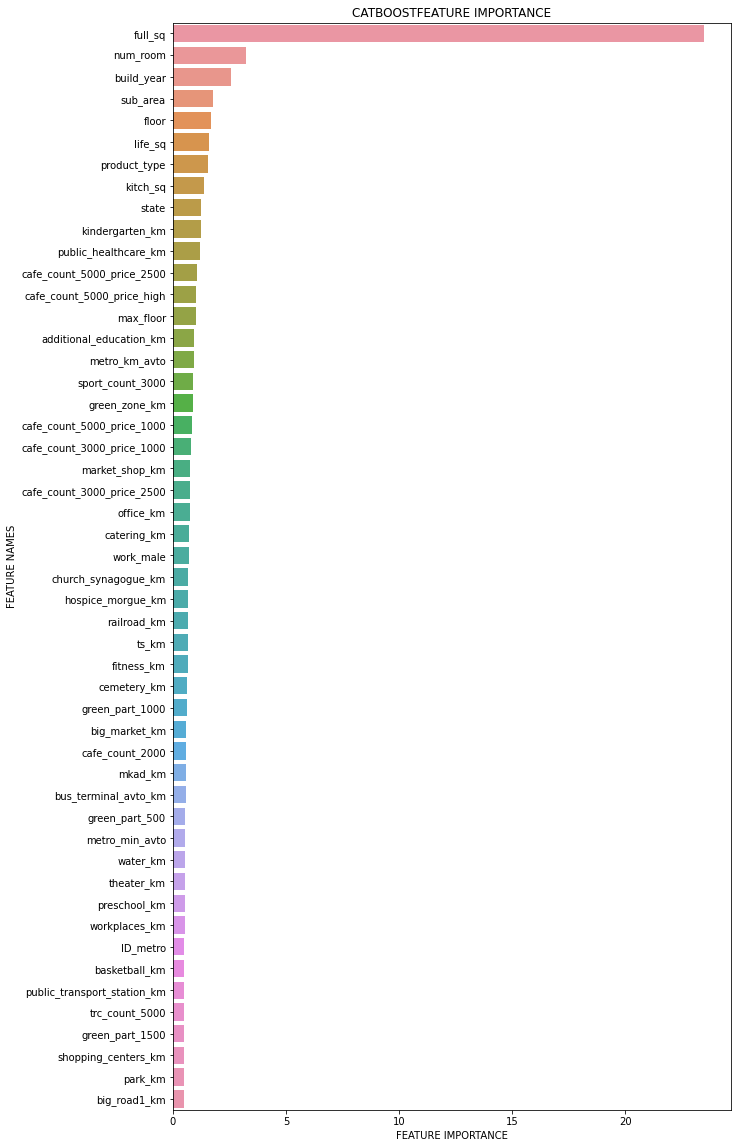

In [369]:
plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST')

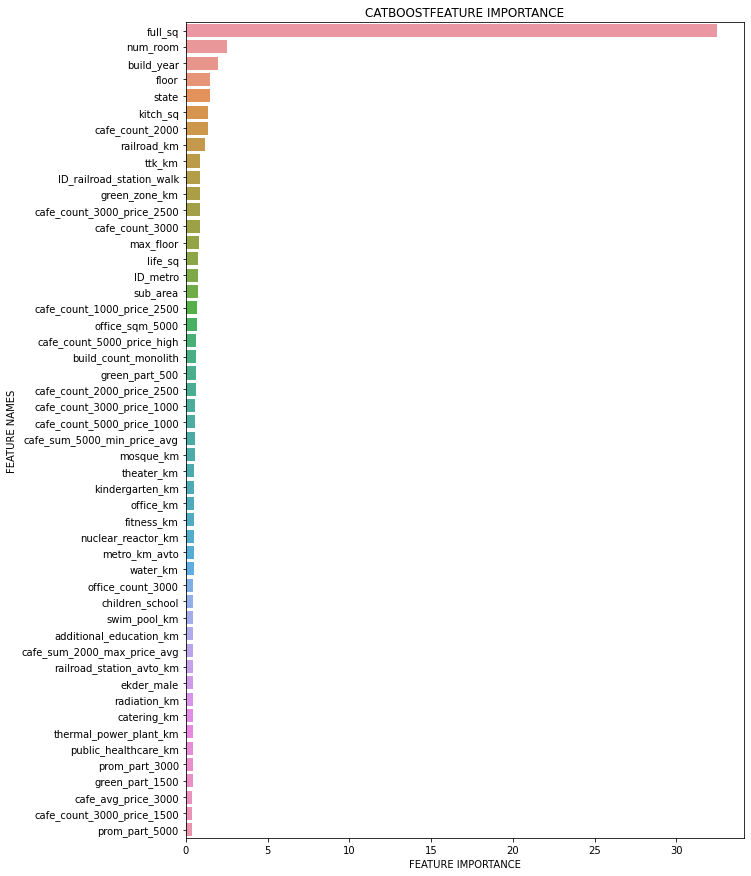

In [26]:
plot_feature_importance(cat_model.get_feature_importance(),X_train.columns,'CATBOOST')

## Загрузка  тестовых значений

In [27]:
submission = pd.DataFrame(columns=['id'], data= raw_test_data)
submission[target] = y_preds_test
submission.head()

,id,price_doc
0,30474,"5,559,131.44"
1,30475,"8,208,846.20"
2,30476,"5,043,102.01"
3,30477,"5,980,853.50"
4,30478,"4,741,054.22"


In [28]:
submission.to_csv("submission.csv", index = False)


In [29]:
!kaggle competitions submit -c sberbank-russian-housing-market -f "submission.csv" -m "the first attempt"

100% 180k/180k [00:02<00:00, 63.2kB/s]
Successfully submitted to Sberbank Russian Housing Market

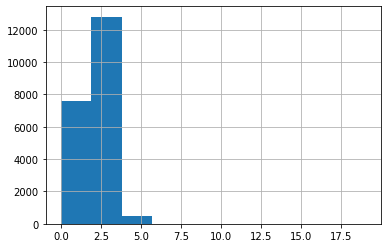

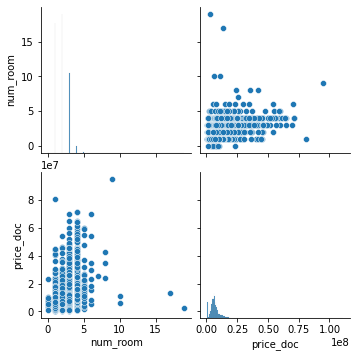

In [10]:
df['num_room'].hist()
sns.pairplot(df[['num_room', 'price_doc']])

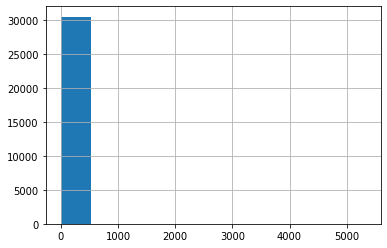

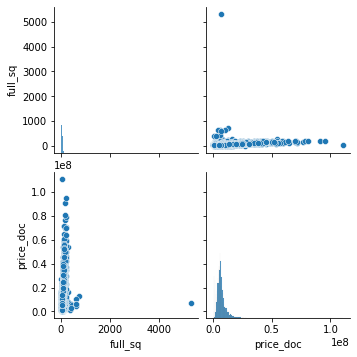

In [214]:
df['full_sq'].hist()
sns.pairplot(df[['full_sq', 'price_doc']])

Text(0.5, 1.0, 'The percentage of missing values per column')

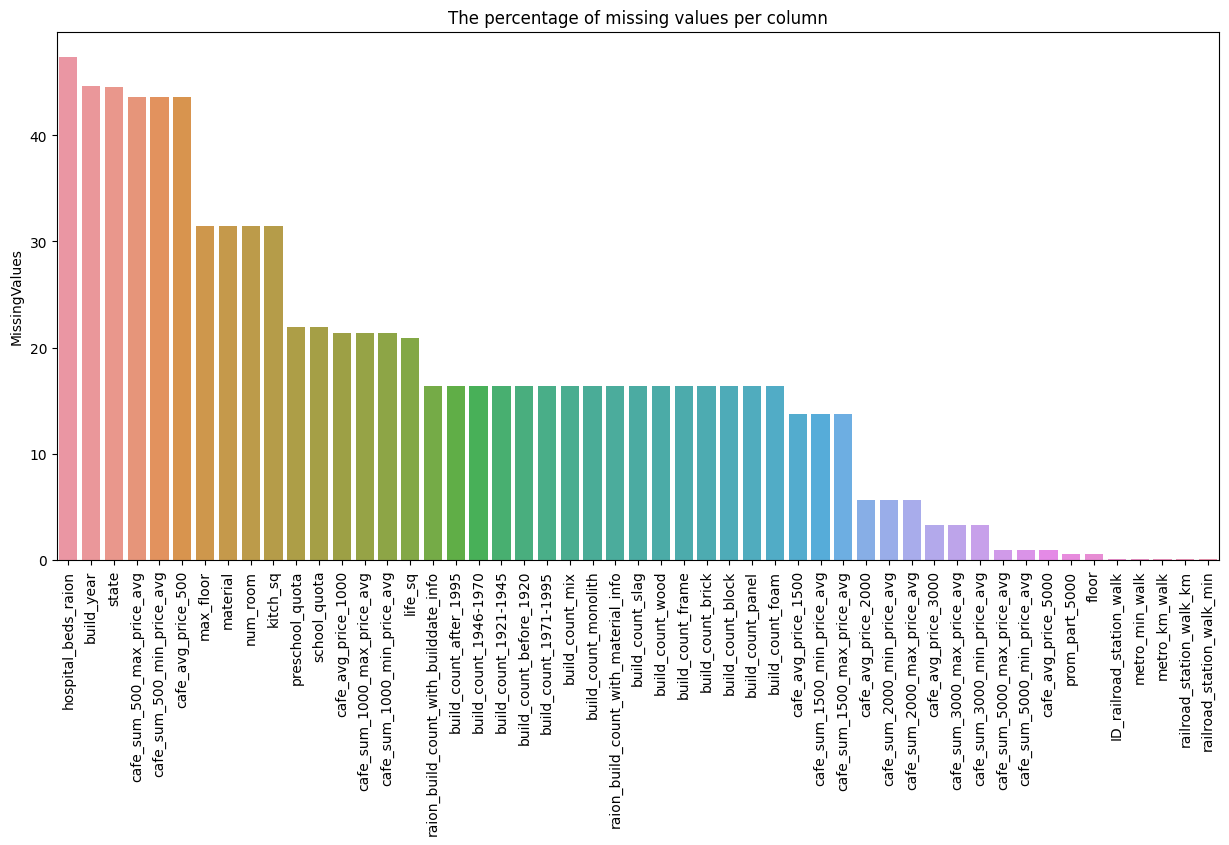

In [233]:
all_df = df

missings_df={}
for key in all_df.columns:
    if all_df[key].isnull().sum() > 0:
        missings_df[key]=(all_df[key].isnull().sum()  /  len(all_df[key]) ) * 100

#Create missing values dataframe
missings_df=pd.DataFrame(missings_df,index=['MissingValues']).T.sort_values(by='MissingValues',ascending=False)

#Plotting the percentage of missing values per column
plt.figure(figsize=(15,7),dpi=100)
plt.xticks(rotation=90)
sns.barplot(y=missings_df.MissingValues,x=missings_df.index, orient='v').set_title('The percentage of missing values per column')

In [ ]:
missings_df
mask =[ not (c in  missings_df.index) and (missings_df.loc['life_sq', "MissingValues"] >20 ) for c in df.columns ]

filterred_cols = df.columns[mask]
filterred_cols.size

missings_df.head(30)

In [251]:
for col in df.columns:
  if col.startswith('cafe_sum'):
    print(col, sep="' , '")

cafe_sum_500_min_price_avg
cafe_sum_500_max_price_avg
cafe_sum_1000_min_price_avg
cafe_sum_1000_max_price_avg
cafe_sum_1500_min_price_avg
cafe_sum_1500_max_price_avg
cafe_sum_2000_min_price_avg
cafe_sum_2000_max_price_avg
cafe_sum_3000_min_price_avg
cafe_sum_3000_max_price_avg
cafe_sum_5000_min_price_avg
cafe_sum_5000_max_price_avg


In [285]:
df['ecology'].value_counts()


poor            8018
no data         7656
good            7174
excellent       3938
satisfactory    3685
Name: ecology, dtype: int64

In [271]:
columns_for_mean = ['cafe_sum_500_min_price_avg',
  'cafe_sum_500_min_price_avg',
  'cafe_sum_500_max_price_avg',
  'cafe_sum_1000_min_price_avg',
  'cafe_sum_1000_max_price_avg',
  'cafe_sum_1500_min_price_avg',
  'cafe_sum_1500_max_price_avg',
  'cafe_sum_2000_min_price_avg',
  'cafe_sum_2000_max_price_avg',
  'cafe_sum_3000_min_price_avg',
  'cafe_sum_3000_max_price_avg',
  'cafe_sum_5000_min_price_avg',
  'cafe_sum_5000_max_price_avg'
  ]
def fillNuMean(dataframe, columns):
  for col_name in columns:
   # print (col_name)
    dataframe[col_name] = dataframe[col_name].fillna((dataframe[col_name].mean()))
  return dataframe

df = fillNuMean(df, columns_for_mean)

In [272]:
def process_data(data):

  #build_year
  isValid = ( data['build_year'] > 1700 ) & ( data['build_year'] < 2022 )
  mean = data['build_year'][isValid].mean()
  data['build_year'][data['build_year'] < 100] = data['build_year'] + 1900
  data['build_year'][(~isValid)] = mean

  #state
  isValid = ( data['state'] <= 5 ) & ( data['state'] >= 1 )
  mean = data['state'][isValid].mean()
  print(mean)

  data['state'][(~isValid)] = mean

  #material
  data['material'][data['material'].isna()] = 0

  return data

      
df = process_data(df) 

2.105197800248498


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A val

In [287]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
X = [['poor', 1], ['satisfactory', 2], ['no data', 2], ['good', 3] , ['excellent', 4]]
enc.fit(X)
ecology_col=enc.transform(df.ecology)
ecology_col

ValueError: ignored

1980.830921598771


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


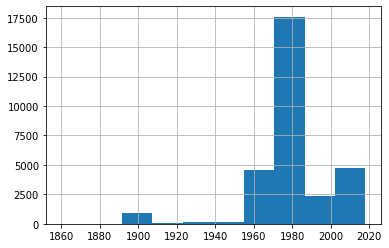

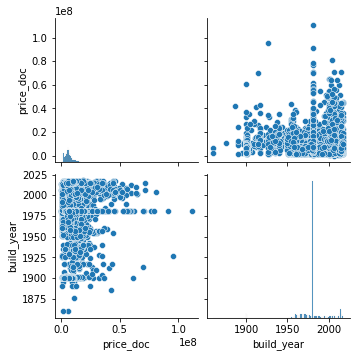

In [201]:
df['build_year'].hist()
sns.pairplot(df[['price_doc','build_year', ]])

2.11    13560
2.00     5844
3.00     5790
1.00     4855
4.00      422
Name: state, dtype: int64

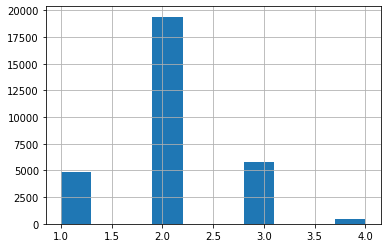

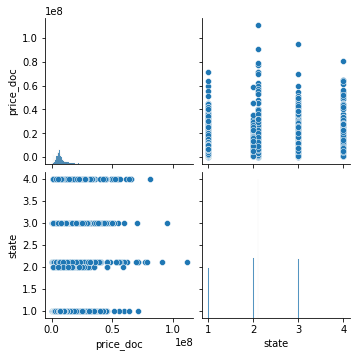

In [241]:
df['state'].hist()
sns.pairplot(df[['price_doc','state', ]])
df.state.value_counts()

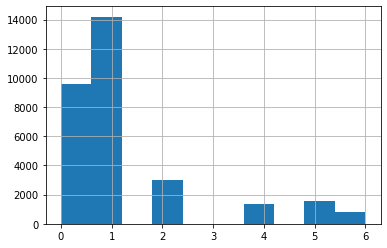

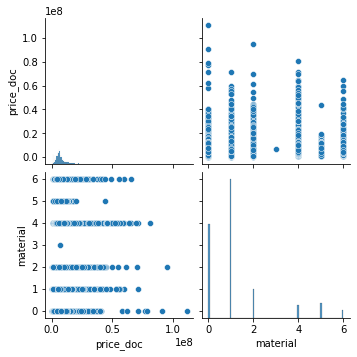

In [260]:
df['material'].hist()
sns.pairplot(df[['price_doc','material', ]])

In [289]:
columns = ['full_sq', \
           'life_sq', 
           'floor', \
           'max_floor', \
           'material', \
           'build_year',  \
           'num_room' , \
           'kitch_sq', \
           'state',
         
           #'product_type', 
       #'sub_area', 
       'area_m', 
       'raion_popul', 
       'green_zone_part',\
       'indust_part', 'children_preschool', 'preschool_quota',\
       'preschool_education_centers_raion', 
       'children_school', 'school_quota',\
       'school_education_centers_raion',\
       'school_education_centers_top_20_raion', 
       'healthcare_centers_raion', 'university_top_20_raion',\
       'sport_objects_raion', 'additional_education_raion',\
       #'culture_objects_top_25'\


      'culture_objects_top_25_raion', 'shopping_centers_raion',
       'office_raion', 
      #'thermal_power_plant_raion',  #'incineration_raion',
       #'oil_chemistry_raion', #'radiation_raion', #'railroad_terminal_raion',
      #'big_market_raion', 
      #'nuclear_reactor_raion', 'detention_facility_raion',
       'full_all', 'male_f', 'female_f', 'young_all', 'young_male',
       'young_female', 'work_all', 'work_male', 'work_female', 'ekder_all',
       'ekder_male', 'ekder_female', '0_6_all', '0_6_male', '0_6_female',
       '7_14_all', '7_14_male', '7_14_female', '0_17_all',


       '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female',
       '0_13_all', '0_13_male', '0_13_female',
       'raion_build_count_with_material_info', 'build_count_block',
       'build_count_wood', 'build_count_frame', 'build_count_brick',
       'build_count_monolith', 'build_count_panel', 'build_count_foam',
       'build_count_slag', 'build_count_mix',
       'raion_build_count_with_builddate_info', 'build_count_before_1920',
       'build_count_1921-1945', 'build_count_1946-1970',
       'build_count_1971-1995', 'build_count_after_1995', 'ID_metro',
       'metro_min_avto', 'metro_km_avto', 'metro_min_walk', 'metro_km_walk',
       'kindergarten_km', 'school_km', 'park_km', 'green_zone_km',
       'industrial_km', 'water_treatment_km', 'cemetery_km', 'incineration_km',
       'railroad_station_walk_km', 'railroad_station_walk_min',
       'ID_railroad_station_walk',


       'railroad_station_avto_km', 'railroad_station_avto_min',
       'ID_railroad_station_avto', 'public_transport_station_km',
       'public_transport_station_min_walk', 'water_km', 
       #'water_1line',
       'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km',
       'big_road1_km', 
       #'ID_big_road1', 'big_road1_1line', 
       'big_road2_km',
       #'ID_big_road2', 
       'railroad_km', 
       #'railroad_1line', 'zd_vokzaly_avto_km',
       'ID_railroad_terminal', 'bus_terminal_avto_km', 'ID_bus_terminal',
       'oil_chemistry_km', 'nuclear_reactor_km', 'radiation_km',
       'power_transmission_line_km', 'thermal_power_plant_km', 'ts_km',
       'big_market_km', 'market_shop_km', 'fitness_km', 'swim_pool_km',
       'ice_rink_km', 'stadium_km', 'basketball_km', 'hospice_morgue_km',
       'detention_facility_km', 'public_healthcare_km', 'university_km',


       'workplaces_km', 'shopping_centers_km', 'office_km',
       'additional_education_km', 'preschool_km', 'big_church_km',
       'church_synagogue_km', 'mosque_km', 'theater_km', 'museum_km',
       'exhibition_km', 'catering_km',
       #'ecology', #
       'green_part_500',
       'prom_part_500', 'office_count_500', 'office_sqm_500', 'trc_count_500',
       'trc_sqm_500', 'cafe_count_500', 'cafe_sum_500_min_price_avg',
       'cafe_sum_500_max_price_avg', 'cafe_avg_price_500',
       'cafe_count_500_na_price', 'cafe_count_500_price_500',
       'cafe_count_500_price_1000', 'cafe_count_500_price_1500',
       'cafe_count_500_price_2500', 'cafe_count_500_price_4000',
       'cafe_count_500_price_high', 'big_church_count_500', 'church_count_500',
       'mosque_count_500', 'leisure_count_500', 'sport_count_500',
       'market_count_500', 'green_part_1000', 'prom_part_1000',
       'office_count_1000', 'office_sqm_1000',


      #  'trc_count_1000', 'trc_sqm_1000', 'cafe_count_1000',
      #  'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg',
      #  'cafe_avg_price_1000', 'cafe_count_1000_na_price',
      #  'cafe_count_1000_price_500', 'cafe_count_1000_price_1000',
      #  'cafe_count_1000_price_1500', 'cafe_count_1000_price_2500',
      #  'cafe_count_1000_price_4000', 'cafe_count_1000_price_high',
      #  'big_church_count_1000', 'church_count_1000', 'mosque_count_1000',
      #  'leisure_count_1000', 'sport_count_1000', 'market_count_1000',
      #  'green_part_1500', 'prom_part_1500', 'office_count_1500',
      #  'office_sqm_1500', 'trc_count_1500', 'trc_sqm_1500', 'cafe_count_1500',
      #  'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg',
      #  'cafe_avg_price_1500', 'cafe_count_1500_na_price',
      #  'cafe_count_1500_price_500', 'cafe_count_1500_price_1000',
      #  'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500',
      #  'cafe_count_1500_price_4000', 'cafe_count_1500_price_high',
      #  'big_church_count_1500', 'church_count_1500', 'mosque_count_1500',
      #  'leisure_count_1500',


      #  'sport_count_1500', 'market_count_1500', 'green_part_2000',
      #  'prom_part_2000', 'office_count_2000', 'office_sqm_2000',
      #  'trc_count_2000', 'trc_sqm_2000', 'cafe_count_2000',
      #  'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg',
      #  'cafe_avg_price_2000', 'cafe_count_2000_na_price',
      #  'cafe_count_2000_price_500', 'cafe_count_2000_price_1000',
      #  'cafe_count_2000_price_1500', 'cafe_count_2000_price_2500',
      #  'cafe_count_2000_price_4000', 'cafe_count_2000_price_high',
      #  'big_church_count_2000', 'church_count_2000', 'mosque_count_2000',
      #  'leisure_count_2000', 'sport_count_2000', 'market_count_2000',
      #  'green_part_3000', 'prom_part_3000', 'office_count_3000',
      #  'office_sqm_3000', 'trc_count_3000', 'trc_sqm_3000', 'cafe_count_3000',
      #  'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
      #  'cafe_avg_price_3000', 'cafe_count_3000_na_price',
      #  'cafe_count_3000_price_500', 'cafe_count_3000_price_1000',
      #  'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500',



      #  'cafe_count_3000_price_4000', 'cafe_count_3000_price_high',
      #  'big_church_count_3000', 'church_count_3000', 'mosque_count_3000',
      #  'leisure_count_3000', 'sport_count_3000', 'market_count_3000',
      #  'green_part_5000', 'prom_part_5000', 'office_count_5000',
      #  'office_sqm_5000', 'trc_count_5000', 'trc_sqm_5000', 'cafe_count_5000',
      #  'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg',
      #  'cafe_avg_price_5000', 'cafe_count_5000_na_price',
      #  'cafe_count_5000_price_500', 'cafe_count_5000_price_1000',
      #  'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500',
      #  'cafe_count_5000_price_4000', 'cafe_count_5000_price_high',
      #  'big_church_count_5000', 'church_count_5000', 'mosque_count_5000',
      #  'leisure_count_5000', 'sport_count_5000', 'market_count_5000',






           ]
object_cols = [ 'id','timestamp',       
           'product_type', 
       'sub_area',
       'culture_objects_top_25', 
           'thermal_power_plant_raion',  'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
      'big_market_raion', 
      'nuclear_reactor_raion', 'detention_facility_raion',
               
               'water_1line',
       'ID_big_road1', 'big_road1_1line', 
       'ID_big_road2', 
       'railroad_1line', 'zd_vokzaly_avto_km',
       'ecology', 
       'price_doc']
#columns =  [x for x in filterred_cols if x not in  object_cols]

ecology=df['ecology']
df = fillNuMean(df, columns)
df['ecology'] = ecology


In [290]:
target = 'price_doc'
y = df[target]
X = df.drop(target, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [275]:



#product_type: owner-occupier purchase or investment
#'sub_area'].unique()
#df['state'].hist(bins=30)

#df['state'].value_counts()


df[columns].isnull().sum()

full_sq              0
life_sq              0
floor                0
max_floor            0
material             0
                    ..
market_count_500     0
green_part_1000      0
prom_part_1000       0
office_count_1000    0
office_sqm_1000      0
Length: 160, dtype: int64

In [17]:
corr = df[columns].corr()


In [19]:

corr = df[columns].corr()


In [20]:
corr

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,...,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
full_sq,1.00,0.13,0.09,0.04,0.02,-0.00,0.21,0.01,-0.04,0.06,-0.04,0.03,-0.05,-0.03,-0.02,-0.01,-0.02,-0.01,-0.01,0.02,-0.01,-0.01,0.05,0.03,0.01,0.03,0.01,0.03,0.01,0.01,0.01,-0.03,-0.02,-0.03,-0.04,-0.04,-0.04,-0.05,-0.04,-0.05,...,0.04,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04,0.04,0.04,0.03,0.03,0.02,0.03,0.01,-0.04,0.00,-0.06,0.03,0.03,0.00,-0.01,0.03,0.04,0.04,0.04,0.03,0.03,0.03,0.04,0.04,0.04,0.04,0.03,0.03,0.02,0.03,0.00,-0.04
life_sq,0.13,1.00,-0.01,0.03,0.04,-0.00,0.12,0.02,0.06,-0.05,0.07,-0.02,-0.02,0.06,0.04,0.05,0.06,0.04,0.06,0.02,0.04,0.05,0.03,0.06,0.01,-0.00,0.04,0.02,0.01,0.01,0.01,0.06,0.06,0.06,0.06,0.07,0.06,0.07,0.07,0.07,...,0.02,-0.01,-0.01,-0.01,0.02,0.02,0.02,0.02,0.02,0.01,0.02,0.02,0.02,0.03,0.01,0.07,0.05,-0.03,0.03,0.03,0.04,0.07,0.06,0.04,0.00,-0.00,-0.00,0.04,0.04,0.04,0.04,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.06,0.05
floor,0.09,-0.01,1.00,0.23,-0.02,-0.00,-0.03,-0.01,-0.10,-0.02,-0.04,-0.00,-0.02,-0.01,0.01,0.02,-0.01,0.03,-0.00,-0.01,-0.09,-0.07,0.00,-0.03,0.05,0.01,0.02,-0.02,-0.03,-0.03,-0.03,-0.01,-0.01,-0.01,-0.04,-0.04,-0.04,-0.08,-0.08,-0.08,...,-0.01,0.07,0.08,0.08,-0.02,-0.02,-0.02,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,0.00,-0.01,-0.08,-0.08,-0.04,-0.09,-0.05,-0.06,-0.08,-0.08,-0.04,0.05,0.05,0.05,-0.05,-0.05,-0.05,-0.04,-0.03,-0.03,-0.02,-0.04,-0.04,-0.01,-0.04,-0.10,-0.12
max_floor,0.04,0.03,0.23,1.00,0.25,0.01,0.56,0.10,0.32,-0.06,0.01,0.03,-0.01,0.03,0.04,0.04,0.03,0.04,0.02,0.00,-0.06,-0.02,0.01,0.01,0.05,0.03,0.03,0.00,0.01,0.01,0.01,0.03,0.03,0.03,0.01,0.01,0.01,-0.01,-0.01,-0.01,...,0.00,-0.06,-0.05,-0.05,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,-0.03,0.01,-0.04,-0.03,-0.03,-0.02,-0.02,-0.02,-0.04,-0.04,-0.02,0.00,0.01,0.01,-0.02,-0.02,-0.02,-0.01,-0.01,-0.01,-0.00,-0.02,-0.02,-0.07,-0.01,-0.05,-0.06
material,0.02,0.04,-0.02,0.25,1.00,0.00,0.22,0.07,0.15,-0.00,-0.03,0.02,-0.02,-0.04,-0.08,-0.06,-0.04,-0.07,-0.03,-0.01,0.06,0.03,0.04,0.04,-0.05,-0.00,-0.04,0.02,0.02,0.02,0.02,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.00,0.00,-0.01,...,0.01,0.00,-0.00,0.00,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,-0.02,0.01,0.06,0.04,0.00,0.07,0.05,0.08,0.05,0.06,0.05,0.08,0.07,0.08,0.05,0.05,0.05,0.05,0.05,0.04,0.04,0.04,0.04,0.02,0.04,0.08,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [21]:


f, ax = plt.subplots(figsize=(10, 7))
highcorr_vars = (corr['full_sq'].sort_values(ascending=False)).index
sns.heatmap(raw_train_data[highcorr_vars].corr(), annot=True)
plt.show()

KeyboardInterrupt: ignored

## Модель

In [295]:
columns.append('ecology')
XX = X_train[columns]

In [ ]:
!pip install -q catboost shap

In [296]:
from catboost import CatBoostRegressor


model = CatBoostRegressor(cat_features= [ecology])
# Fit model
model.fit(XX, y_train)





CatBoostError: ignored

In [279]:
y_pred = model.predict(X_val[columns])

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score





print(mean_squared_error(y_pred, y_val))

print(mean_absolute_error(y_pred, y_val))
print(r2_score(y_pred, y_val))
print(mean_squared_log_error(y_pred, y_val))







6134643457693.519
1349090.0535192292
0.5815283965206446
0.2171649093331063


In [268]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    fi_df = fi_df.head(50)
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

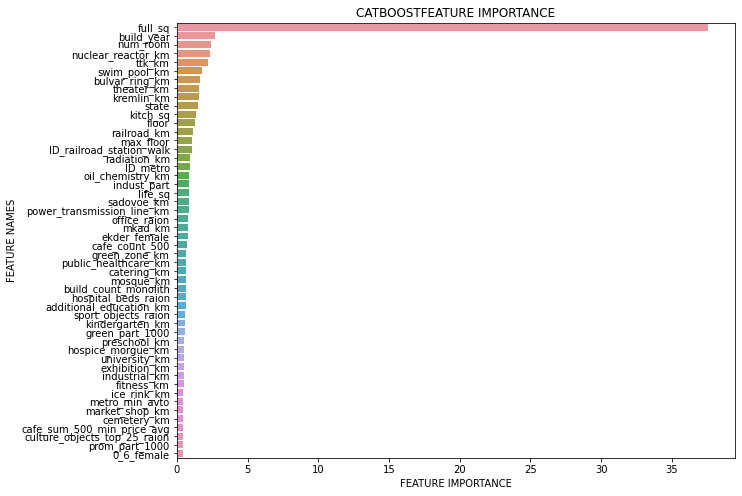

In [280]:
plot_feature_importance(model.get_feature_importance(),XX.columns,'CATBOOST')
